In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tifffile import imread
from tqdm import tqdm
from decimal import Decimal
from scipy.stats import zscore, spearmanr, pearsonr, gaussian_kde
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture

sys.path.append("../../coexist")# # path to coexist
import coexist

In [15]:
def solve(m1,m2,std1,std2):
    """
    Finds intersection of two Gaussians. Source: https://stackoverflow.com/questions/22579434/python-finding-the-intersection-point-of-two-gaussian-curves'
    Parameters:
    - m1, std1: float, mean and standard dev of Gaussian 1
    - m2, std2: float, mean and standard dev of Gaussian 2
    Returns:
    - intersection: float, intersection of Guassians
    """
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    roots = np.roots([a,b,c])
    m_low, m_high = min(m1,m2), max(m1,m2)
    if m_low < roots[0] < m_high:
        intersection = roots[0]
    elif m_low < roots[1] < m_high:
        intersection = roots[1]
    else:
        intersection = None
        print('Fail')
    return intersection

## Run COEXIST

In [16]:
core = 'B4'
dir_ = '/home/groups/ChangLab/heussner/coexist/figures/4/masks_and_tables'
slide_1_mask = imread(os.path.join(dir_,f'{core}_mIHC.tif')) # registered segmentation masks
slide_2_mask = imread(os.path.join(dir_,f'{core}_cyCIF.tif'))
slide_1_table = pd.read_csv(os.path.join(dir_,f'{core}_mIHC.csv')) # corresponding feature tables
slide_2_table = pd.read_csv(os.path.join(dir_,f'{core}_cyCIF.csv'))
shared_dict = {'DSDNA':'DNA_1', # dict of shared markers (slide_1:slide_2)
               'CD3':'CD3',
               'PDL1':'PDL1',
               'GRZB':'GRZB',
               'FOXP3':'FOXP3',
               'KI67':'Ki67',
               'PANCK':'PanCK',
               'SMA':'aSMA',
               'CD45':'CD45',
               'CD163':'CD163',
               'CD8':'CD8a',
               'PDL1':'PDL1',
               'CD20':'CD20',
               'CD11B':'CD11b',
               'HLAII':'HLA_A',
               'PD1':'PD1'}

In [17]:
slide_1_table.head() # confirm column names

,Unnamed: 0,CellID,NUCLEI,PDL1,PD1,CD45,DCLAMP,EOMES,CD3,HLAII,...,Y_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation,x,y
0,0,3,11.163636,0.527273,0.309091,12.975758,1.884848,4.169697,13.527273,1.254545,...,369.303030,165,18.349865,11.609921,0.774399,0.926966,0.668016,1.287390,336.428571,1609.571429
1,1,4,15.956522,1.929348,0.967391,5.793478,2.029891,10.676630,11.535326,12.448370,...,378.307065,368,31.733584,15.810767,0.867042,0.830700,0.547619,0.621267,345.608333,1606.358333
2,2,5,25.883817,0.875519,0.394191,18.788382,2.630705,5.020747,15.705394,2.825726,...,381.995851,241,20.050439,15.458938,0.636832,0.941406,0.746130,0.726022,346.012048,1616.662651
3,3,6,10.857955,3.346591,0.676136,4.517045,2.380682,15.289773,10.659091,56.187500,...,386.670455,176,18.121131,12.477858,0.725160,0.946237,0.752137,0.263901,349.655172,1599.034483
4,4,7,34.788462,3.024038,0.634615,4.942308,3.028846,12.230769,12.908654,6.509615,...,395.057692,208,18.353191,14.693020,0.599239,0.916300,0.643963,1.029960,354.833333,1612.781250


In [18]:
model = coexist.model.COEXIST(im1_mask=slide_1_mask, # instantiate model
                           im2_mask=slide_2_mask,
                           df1 = slide_1_table,
                           df2 = slide_2_table,
                           cellID_key = 'CellID',
                           shared_markers=shared_dict,
                           method='coexist',
                           diameter_key='MajorAxisLength',
                           mpp1=0.5,
                           mpp2=0.65,
                           thickness=5)

In [19]:
model.preprocess_data() # standardize features, compute cost matrices

Computing cost matrix
Done preprocessing


In [20]:
model.match_cells() # perform matching #variables df1_matched, df2_matched defined

Matching cells
Removing low quality matches
Matched 4011 cells of 9732 slide 1 cells and 9714 slide 2 cells,  41.3% shared.


In [21]:
model.check_correlations() # check match quality by single-cell Spearman correlation

DSDNA/DNA_1: 0.34
CD3/CD3: 0.5
PDL1/PDL1: 0.34
GRZB/GRZB: 0.19
FOXP3/FOXP3: 0.13
KI67/Ki67: 0.45
PANCK/PanCK: 0.81
SMA/aSMA: 0.36
CD45/CD45: 0.72
CD163/CD163: 0.35
CD8/CD8a: 0.42
CD20/CD20: 0.17
CD11B/CD11b: 0.26
HLAII/HLA_A: 0.33
PD1/PD1: 0.34


## View single-cell scatter plots

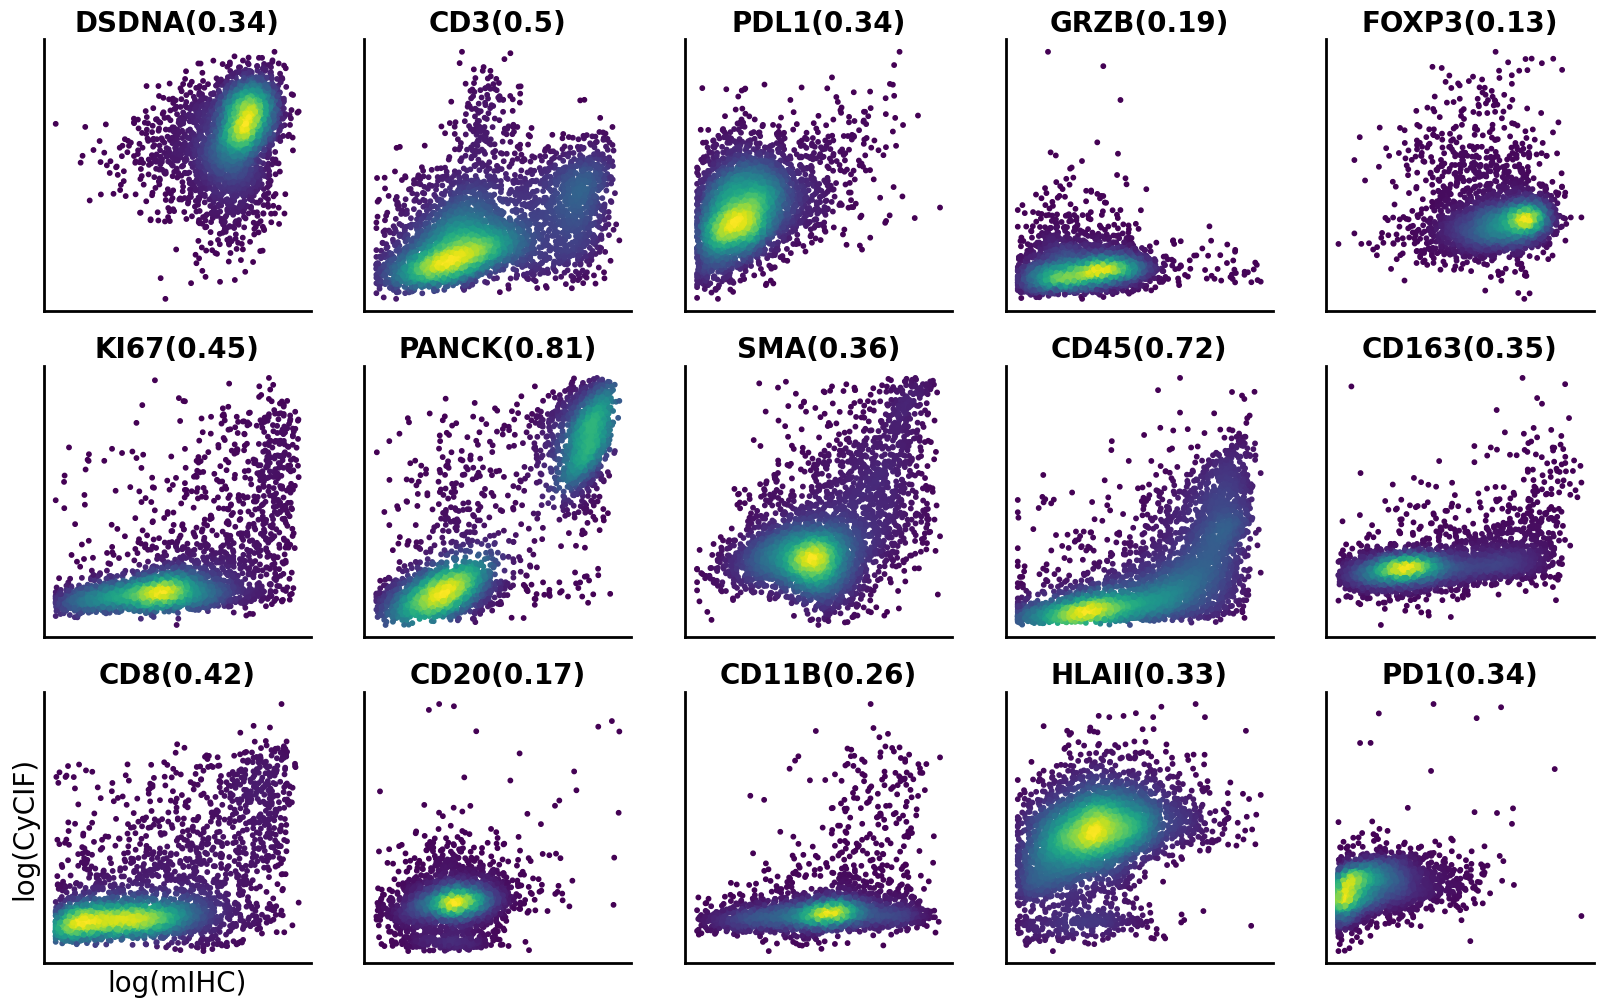

In [23]:
fig, ax = plt.subplots(3,5,figsize=(20,12)) # single-cell scatter plots
ax = ax.flatten()
for i, (m1, m2) in enumerate(shared_dict.items()):
    f1 = np.log(1+model.df1_matched[m1])
    f2 = np.log(1+model.df2_matched[m2])
    xy = np.vstack([f1,f2])
    z = gaussian_kde(xy)(xy)
    sp = np.round(spearmanr(f1,f2)[0],2)
    ax[i].set_title(f'{m1}({sp})',fontsize=20, weight='bold')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(f1, f2, c=z, s=10)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

ax[10].set_xlabel('log(mIHC)',fontsize=20)
ax[10].set_ylabel('log(CyCIF)',fontsize=20)
fig.show()

## Population-level comparison

In [24]:
shared_dict = {'CD3':'CD3', # choose markers w/positive and negative populations
               'KI67':'Ki67',
               'PANCK':'PanCK',
               'SMA':'aSMA',
               'CD45':'CD45',
               'CD163':'CD163',
               'CD8':'CD8a',
               'PDL1':'PDL1',
               'CD11B':'CD11b',
               'HLAII':'HLA_A'}

slide_1_all = [] # fractions of positive cells (all cells) for each marker in slide 1 
slide_2_all = [] # fractions of positive cells (all cells) for each marker in slide 2 
slide_1_shared = [] # fractions of positive cells (only shared cells) for each marker in slide 1 
slide_2_shared = [] # fractions of positive cells (only shared cells) for each marker in slide 2 

slide_1_thresholds = [] # GMM thresholds for each marker
slide_2_thresholds = []

for m1,m2 in tqdm(shared_dict.items()):
    GMM = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    GMM.fit(np.array(slide_1_table[m1]).reshape(-1, 1))
    t = solve(GMM.means_[0][0], GMM.means_[1][0], GMM.covariances_[0][0][0]**.5, GMM.covariances_[1][0][0]**.5)
    slide_1_all.append(len(slide_1_table[slide_1_table[m1]>t])/len(slide_1_table))

    GMM = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    GMM.fit(np.array(model.df1_matched[m1]).reshape(-1, 1))
    t = solve(GMM.means_[0][0], GMM.means_[1][0], GMM.covariances_[0][0][0]**.5, GMM.covariances_[1][0][0]**.5)
    slide_1_shared.append(len(model.df1_matched[model.df1_matched[m1]>t])/len(model.df1_matched))
    slide_1_thresholds.append(t)

    GMM = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    GMM.fit(np.array(slide_2_table[m2]).reshape(-1, 1))
    t = solve(GMM.means_[0][0], GMM.means_[1][0], GMM.covariances_[0][0][0]**.5, GMM.covariances_[1][0][0]**.5)
    slide_2_all.append(len(slide_2_table[slide_2_table[m2]>t])/len(slide_2_table))

    GMM = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    GMM.fit(np.array(model.df2_matched[m2]).reshape(-1, 1))
    t = solve(GMM.means_[0][0], GMM.means_[1][0], GMM.covariances_[0][0][0]**.5, GMM.covariances_[1][0][0]**.5)
    slide_2_shared.append(len(model.df2_matched[model.df2_matched[m2]>t])/len(model.df2_matched))
    slide_2_thresholds.append(t)

100%|████████████████████████████████| 10/10 [00:03<00:00,  2.75it/s]


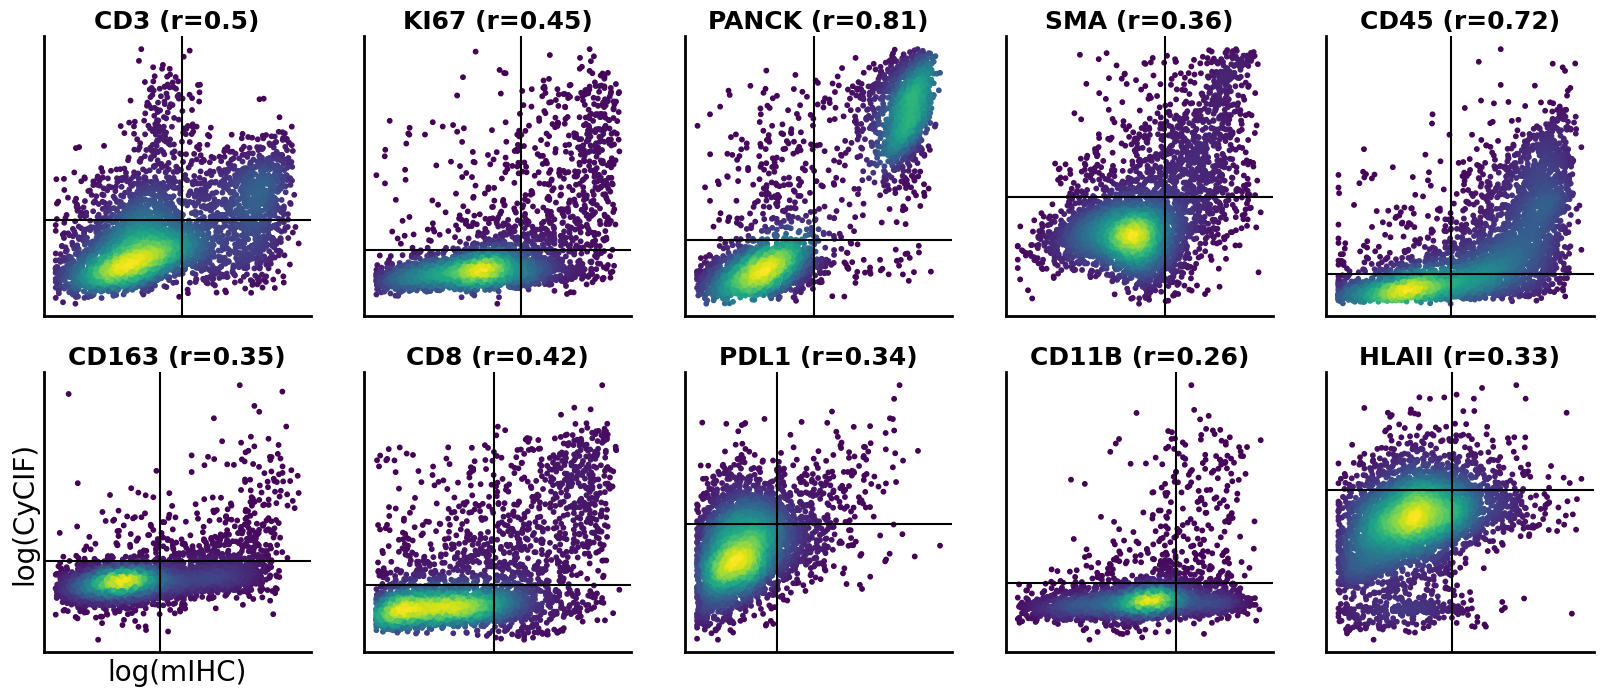

In [25]:
fig, ax = plt.subplots(2,5,figsize=(20,8)) # scatter plots with GMM thresholds
ax = ax.flatten()
for i, (m1, m2) in enumerate(shared_dict.items()):
    f1 = np.log(1+model.df1_matched[m1])
    f2 = np.log(1+model.df2_matched[m2])
    xy = np.vstack([f1,f2])
    z = gaussian_kde(xy)(xy)
    sp = np.round(spearmanr(f1,f2)[0],2)
    ax[i].set_title(f'{m1} (r={sp})',fontsize=18,weight='bold')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(f1, f2, c=z, s=10)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].axvline(np.log(1+slide_1_thresholds[i]),color='black')
    ax[i].axhline(np.log(1+slide_2_thresholds[i]),color='black')
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
ax[5].set_xlabel('log(mIHC)',fontsize=20)
ax[5].set_ylabel('log(CyCIF)',fontsize=20)
fig.show()

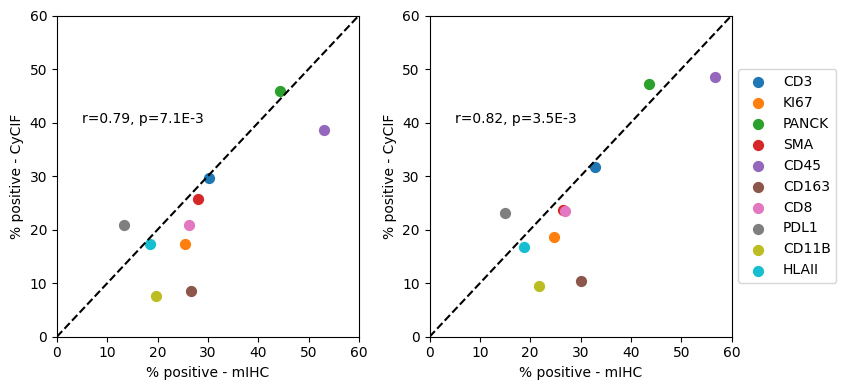

In [26]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
for i, (m1,m2) in enumerate(shared_dict.items()):
    ax[0].scatter(slide_1_all[i]*100, slide_2_all[i]*100, zorder=1, label=m1, s=50)
    ax[1].scatter(slide_1_shared[i]*100, slide_2_shared[i]*100, zorder=1, label=m1, s=50)

ax[0].set_xlabel('% positive - mIHC')
ax[0].set_ylabel('% positive - CyCIF')
ax[0].text(5,40,f'r={np.round(pearsonr(slide_1_all, slide_2_all)[0],2)}, p={Decimal(str(pearsonr(slide_1_all, slide_2_all)[1])):.1E}')
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,60])
ax[0].plot([0,60],[0,60],linestyle='--',color='black')

ax[1].set_xlabel('% positive - mIHC')
ax[1].set_ylabel('% positive - CyCIF')
ax[1].text(5,40,f'r={np.round(pearsonr(slide_1_shared, slide_2_shared)[0],2)}, p={Decimal(str(pearsonr(slide_1_shared, slide_2_shared)[1])):.1E}')
ax[1].set_xlim([0,60])
ax[1].set_ylim([0,60])
ax[1].plot([0,60],[0,60],linestyle='--',color='black')
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()